<a href="https://colab.research.google.com/github/Hrishikesh6666/Predictive-Transaction-Intelligence-using-for-BFSI/blob/main/fraudditection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv("card_fraud.csv_processed.csv")  # Use exact name shown in upload output
df.head()


,Transaction_Amount,Transaction_Date,Transaction_Time,Transaction_Location,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Authentication_Method,Transaction_Velocity,Transaction_Category,isFraud,Log_Transaction_Amount,Velocity_Distance_Interact
0,69635000,1/1/2024 0:00,0:00:00,Surkhandarya,UzCard,UZS,Successful,35,3481.19,30,2FA,5,Transfer,1,18.058778,17405.95
1,53486000,1/1/2024 0:01,0:01:00,Namangan,UzCard,USD,Successful,35,4341.04,1073,Biometric,9,Cash Out,1,17.794931,39069.36
2,24262000,1/1/2024 0:02,0:02:00,Navoiy,Humo,UZS,Reversed,25,4780.35,132,2FA,7,Cash In,1,17.004422,33462.45
3,56019000,1/1/2024 0:03,0:03:00,Bukhara,Humo,UZS,Failed,44,719.43,41,Biometric,1,Payment,1,17.841201,719.43
4,87823000,1/1/2024 0:04,0:04:00,Andijan,Humo,UZS,Failed,21,4691.06,458,Password,8,Cash Out,1,18.290834,37528.48


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Transaction_Amount                100000 non-null  int64  
 1   Transaction_Date                  100000 non-null  object 
 2   Transaction_Time                  100000 non-null  object 
 3   Transaction_Location              100000 non-null  object 
 4   Card_Type                         100000 non-null  object 
 5   Transaction_Currency              100000 non-null  object 
 6   Transaction_Status                100000 non-null  object 
 7   Previous_Transaction_Count        100000 non-null  int64  
 8   Distance_Between_Transactions_km  100000 non-null  float64
 9   Time_Since_Last_Transaction_min   100000 non-null  int64  
 10  Authentication_Method             100000 non-null  object 
 11  Transaction_Velocity              100000 non-null  in

In [ ]:
df.describe()

,Transaction_Amount,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Transaction_Velocity,isFraud,Log_Transaction_Amount,Velocity_Distance_Interact
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,4.994914e+07,24.995050,2494.472941,719.954050,5.007310,0.500000,17.420842,12491.895423
std,2.882889e+07,14.110348,1447.158281,414.434773,2.579051,0.500003,0.996076,10379.600231
min,1.100000e+04,1.000000,0.010000,1.000000,1.000000,0.000000,9.305741,0.060000
25%,2.511300e+07,13.000000,1235.232500,362.000000,3.000000,0.000000,17.038896,3941.457500
50%,4.979900e+07,25.000000,2497.550000,720.000000,5.000000,0.500000,17.723505,9567.495000
75%,7.503175e+07,37.000000,3746.572500,1078.000000,7.000000,1.000000,18.133422,18879.402500
max,1.000000e+08,49.000000,4999.980000,1439.000000,9.000000,1.000000,18.420681,44996.400000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

# ---- Load dataset (adjust filename/path if needed) ----
df = pd.read_csv("card_fraud.csv_processed.csv")
print("Columns in dataframe:", df.columns.tolist())

# ---- Auto-detect target column (handles common names) ----
possible_targets = ['Class', 'isFraud', 'fraud', 'label', 'target']
target = next((t for t in possible_targets if t in df.columns), None)
if target is None:
    raise ValueError(f"No target column found among {possible_targets}. Columns: {df.columns.tolist()}")
print("Using target column:", target)

# ---- Combine date + time into single datetime if both exist ----
if 'Transaction_Date' in df.columns and 'Transaction_Time' in df.columns:
    # create combined datetime string then parse
    combined = df['Transaction_Date'].astype(str).str.strip() + ' ' + df['Transaction_Time'].astype(str).str.strip()
    df['Transaction_Datetime'] = pd.to_datetime(combined, errors='coerce')
    # drop the originals (optional)
    df = df.drop(columns=['Transaction_Date', 'Transaction_Time'])
    print("Created Transaction_Datetime from date+time.")
else:
    # try to detect any single datetime-like column
    for c in df.columns:
        if df[c].dtype == object:
            parsed = pd.to_datetime(df[c], errors='coerce')
            if parsed.notna().mean() > 0.7:
                df[c] = parsed
                print(f"Parsed column {c} as datetime-like.")


# ---- Optional: drop obvious ID columns if present ----
possible_id_cols = ['id', 'TransactionID', 'txn_id', 'Name']
drop_cols = [c for c in possible_id_cols if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
    print("Dropped ID columns:", drop_cols)

# ---- Separate X and y ----
X = df.drop(columns=[target])
y = df[target]

# ---- Identify types: numeric, object (categorical or datetime), datetime columns ----
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns.tolist()

# For object columns attempt datetime parse -> otherwise categorical
cat_cols = []
for c in obj_cols:
    parsed = pd.to_datetime(X[c], errors='coerce')
    if parsed.notna().mean() > 0.7:
        X[c] = parsed
        datetime_cols.append(c)
    else:
        cat_cols.append(c)

# If we created 'Transaction_Datetime', expand into features
for c in list(datetime_cols):
    X[c + '_year'] = X[c].dt.year
    X[c + '_month'] = X[c].dt.month
    X[c + '_day'] = X[c].dt.day
    X[c + '_hour'] = X[c].dt.hour
    X[c + '_minute'] = X[c].dt.minute
    X[c + '_dayofweek'] = X[c].dt.dayofweek
    X[c + '_is_weekend'] = X[c].dt.dayofweek.isin([5,6]).astype(int)
    # epoch (seconds) - safe conversion, may produce NaN on missing
    X[c + '_epoch'] = pd.to_numeric(X[c].view('int64'), errors='coerce') // 10**9
# drop original datetime object columns
X = X.drop(columns=datetime_cols, errors='ignore')

# Recompute numeric and categorical lists
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.select_dtypes(include=['object','category']).columns.tolist()]

print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

# ---- Train-test split BEFORE resampling to avoid leakage ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- Preprocessing pipelines ----
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop', sparse_threshold=0)

# ---- Fit preprocessor on training set and transform both train and test ----
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print("Prepared shapes -> X_train:", X_train_prep.shape, "X_test:", X_test_prep.shape)

# ---- Apply SMOTE only to training data ----
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_prep, y_train)

print("Class distribution before SMOTE:", y_train.value_counts().to_dict())
print("Class distribution after SMOTE:", pd.Series(y_train_res).value_counts().to_dict())

# ---- Train XGBoost ----
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_res, y_train_res)

# ---- Evaluate ----
y_pred = model.predict(X_test_prep)
y_proba = model.predict_proba(X_test_prep)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Columns in dataframe: ['Transaction_Amount', 'Transaction_Date', 'Transaction_Time', 'Transaction_Location', 'Card_Type', 'Transaction_Currency', 'Transaction_Status', 'Previous_Transaction_Count', 'Distance_Between_Transactions_km', 'Time_Since_Last_Transaction_min', 'Authentication_Method', 'Transaction_Velocity', 'Transaction_Category', 'isFraud', 'Log_Transaction_Amount', 'Velocity_Distance_Interact']
Using target column: isFraud


/tmp/ipython-input-2263320632.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Transaction_Datetime'] = pd.to_datetime(combined, errors='coerce')


Created Transaction_Datetime from date+time.
Numeric cols: 15 Categorical cols: 6


/tmp/ipython-input-2263320632.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(X[c], errors='coerce')
/tmp/ipython-input-2263320632.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(X[c], errors='coerce')
/tmp/ipython-input-2263320632.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(X[c], errors='coerce')
/tmp/ipython-input-2263320632.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expe

Prepared shapes -> X_train: (80000, 41) X_test: (20000, 41)
Class distribution before SMOTE: {0: 40000, 1: 40000}
Class distribution after SMOTE: {0: 40000, 1: 40000}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:27:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



🔍 Model Performance Metrics:
Accuracy      : 1.0000
Precision     : 1.0000
Recall        : 1.0000
F1 Score      : 1.0000
ROC-AUC Score : 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



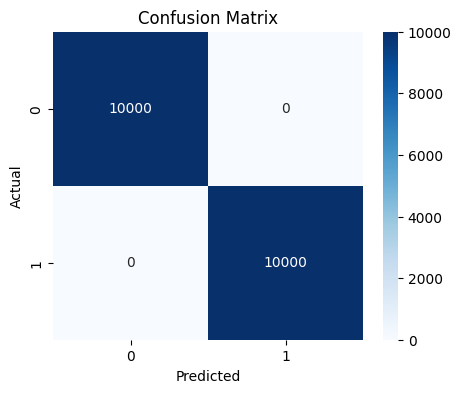

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Make predictions ----
y_pred = model.predict(X_test_prep)
y_proba = model.predict_proba(X_test_prep)[:, 1]

# ---- Calculate metrics ----
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# ---- Print metrics ----
print("🔍 Model Performance Metrics:")
print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC-AUC Score : {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---- Plot Confusion Matrix ----
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

# ---- Make predictions ----
y_pred = model.predict(X_test_prep)
y_proba = model.predict_proba(X_test_prep)[:, 1]

# ---- Calculate metrics ----
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_proba) * 100

# ---- Print results ----
print("📊 Model Evaluation Results:")
print(f"Accuracy      : {accuracy:.2f}%")
print(f"Precision     : {precision:.2f}%")
print(f"Recall        : {recall:.2f}%")
print(f"F1 Score      : {f1:.2f}%")
print(f"ROC-AUC Score : {roc_auc:.2f}%")

print("\nDetailed Classification Report:\n", classification_report(y_test, y_pred))


📊 Model Evaluation Results:
Accuracy      : 100.00%
Precision     : 100.00%
Recall        : 100.00%
F1 Score      : 100.00%
ROC-AUC Score : 100.00%

Detailed Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [ ]:
# save_artifacts.py
import joblib
from pathlib import Path

out_dir = Path("artifacts")
out_dir.mkdir(exist_ok=True)

# model is your trained XGBClassifier, preprocessor is your ColumnTransformer pipeline
joblib.dump(model, out_dir / "xgb_model.pkl")
joblib.dump(preprocessor, out_dir / "preprocessor.pkl")

print("Saved: artifacts/xgb_model.pkl and artifacts/preprocessor.pkl")


Saved: artifacts/xgb_model.pkl and artifacts/preprocessor.pkl


In [ ]:
import numpy as np
import pandas as pd

def ensure_expected_columns_for_preprocessor(df, preprocessor):
    """
    Given a dataframe `df` (raw uploaded) and a fitted ColumnTransformer `preprocessor`,
    ensure df contains all columns that `preprocessor` was originally fitted on.
    - If datetime-derived columns are missing but raw datetime/date/time exist, attempt to create them.
    - Otherwise create the missing columns with NaN (so imputers can handle them).
    Returns a dataframe with the required columns (in any order).
    """

    # 1) Collect expected input column names from the fitted preprocessor
    expected_cols = []
    # preprocessor.transformers_ entries are tuples: (name, transformer, columns)
    for name, transformer, cols in preprocessor.transformers_:
        # cols may be a list/array of column names or integer indices or string 'remainder'
        if cols == 'remainder' or cols is None:
            continue
        # If columns are slice/array-like, extend; otherwise add single
        try:
            expected_cols.extend(list(cols))
        except Exception:
            expected_cols.append(cols)
    expected_cols = list(dict.fromkeys(expected_cols))  # dedupe, preserve order

    # 2) Determine which expected columns are missing from df
    missing = [c for c in expected_cols if c not in df.columns]
    if not missing:
        return df  # nothing to do

    # 3) Attempt to recreate common datetime-derived columns pattern:
    # looks for 'Transaction_Datetime' or separate 'Transaction_Date' and 'Transaction_Time'
    dt_base_names = set()
    for col in missing:
        # common pattern: Transaction_Datetime_year/month/day/hour/minute/dayofweek/is_weekend/epoch
        if col.startswith("Transaction_Datetime_"):
            dt_base_names.add("Transaction_Datetime")

    if "Transaction_Datetime" in dt_base_names:
        # Try parsing a single Transaction_Datetime column if present in raw df
        if "Transaction_Datetime" in df.columns:
            parsed = pd.to_datetime(df["Transaction_Datetime"], errors="coerce")
            df["Transaction_Datetime"] = parsed
        else:
            # Try to build Transaction_Datetime from Transaction_Date and Transaction_Time
            if "Transaction_Date" in df.columns and "Transaction_Time" in df.columns:
                combined = df["Transaction_Date"].astype(str).str.strip() + " " + df["Transaction_Time"].astype(str).str.strip()
                df["Transaction_Datetime"] = pd.to_datetime(combined, errors="coerce")

        # If we have created/parsed Transaction_Datetime, build derived cols
        if "Transaction_Datetime" in df.columns and pd.api.types.is_datetime64_any_dtype(df["Transaction_Datetime"]):
            dt = df["Transaction_Datetime"]
            df["Transaction_Datetime_year"] = dt.dt.year
            df["Transaction_Datetime_month"] = dt.dt.month
            df["Transaction_Datetime_day"] = dt.dt.day
            df["Transaction_Datetime_hour"] = dt.dt.hour
            df["Transaction_Datetime_minute"] = dt.dt.minute
            df["Transaction_Datetime_dayofweek"] = dt.dt.dayofweek
            df["Transaction_Datetime_is_weekend"] = dt.dt.dayofweek.isin([5,6]).astype(int)
            # epoch seconds (safe conversion)
            df["Transaction_Datetime_epoch"] = pd.to_numeric(dt.view("int64"), errors="coerce") // 10**9

    # 4) For any remaining missing columns, add them as NaN (so imputers/scalers handle them)
    for col in missing:
        if col not in df.columns:
            df[col] = np.nan

    # 5) Return df with at least the required columns present
    return df

# -------------------------
# Example usage before transform
# -------------------------
# df = pd.read_csv(uploaded_file)   # your uploaded file
# X = df.drop(columns=[target]) if target in df.columns else df.copy()
# X_aligned = ensure_expected_columns_for_preprocessor(X, preprocessor)
# X_prep = preprocessor.transform(X_aligned)


In [ ]:
import pandas as pd
import numpy as np

# Replace these with the names you used
# model  -> XGBoost (or ensemble) object
# preprocessor -> fitted ColumnTransformer / pipeline used to transform training data

def predict_transaction(model, preprocessor, sample_dict, threshold=0.5):
    """
    sample_dict: dict of single transaction features, keys must match training feature names (except target).
    threshold: probability threshold to call fraud (default 0.5; you can lower to increase recall).
    Returns: dict with probability and label.
    """
    # create DataFrame with single row
    sample_df = pd.DataFrame([sample_dict])

    # Use the helper function to ensure all expected columns are present and handle datetime
    sample_df_aligned = ensure_expected_columns_for_preprocessor(sample_df, preprocessor)

    # Transform using preprocessor
    X_sample_prep = preprocessor.transform(sample_df_aligned)

    # Predict probability and label
    prob = float(model.predict_proba(X_sample_prep)[:, 1][0])  # probability of fraud
    label = "Fraud" if prob >= threshold else "Not Fraud"

    return {"probability": prob, "label": label}

# -------------------------
# Example sample transaction (adjust fields & values to match your dataset)
example = {
    "Transaction_Amount": 2500.00,
    "Transaction_Date": "2025-10-09",
    "Transaction_Time": "23:45:00",
    "Transaction_Location": "Mumbai_Mall_01",
    "Card_Type": "VISA",
    "Transaction_Currency": "INR",
    "Transaction_Status": "Completed",
    "Previous_Transaction_Count": 3,
    "Distance_Between_Transactions_km": 2.5,
    "Time_Since_Last_Transaction_min": 75,
    "Authentication_Method": "PIN",
    "Transaction_Velocity": 0.04,
    "Transaction_Category": "Electronics",
    # Any engineered columns your pipeline expects can be added here as well:
    # "Log_Transaction_Amount": np.log1p(2500.00),
    # "Velocity_Distance_Interact": ...
}

result = predict_transaction(model, preprocessor, example, threshold=0.5)
print(f"Prediction: {result['label']}  (Fraud probability = {result['probability']:.4f})")

Prediction: Not Fraud  (Fraud probability = 0.0000)


/tmp/ipython-input-3573416374.py:62: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["Transaction_Datetime_epoch"] = pd.to_numeric(dt.view("int64"), errors="coerce") // 10**9
